# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

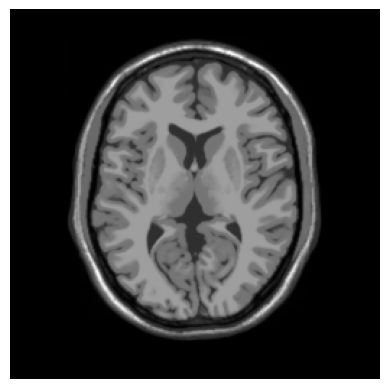

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

#TODO Samodzielna
mat = loadmat('MR_data.mat')

I0 = mat['I_noisefree']
I1 = mat['I_noisy1']
I2 = mat['I_noisy2']
I3 = mat['I_noisy3']
I4 = mat['I_noisy4']

plt.figure()
plt.imshow(I0,'gray')
plt.axis('off')
plt.show()

Zdjęcie przedstawia tomografię mózgu.

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [2]:
#TODO Samodzielna
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()

In [3]:
def new_pixel(window,f):
    value = 0
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            value += window[i,j]*f[i,j]
    return value

def gauss_filter(image,size,var):
    f = np.zeros((size,size))
    C = 1.0 / (2.0*np.pi*var*var)
    for i in range(size):
        for j in range(size):
            x = i - size//2
            y = j - size//2
            res = np.sqrt(x**2+y**2)
            f[i,j] = C*np.exp(-(res**2)/(2.0*var*var))
    mesh(f,size)
    IConv = image.copy()
    for i in range(size//2,image.shape[0]-size//2):
        for j in range(size//2,image.shape[1]-size//2):
            context = image[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            IConv[i,j] = new_pixel(context,f)
    return IConv

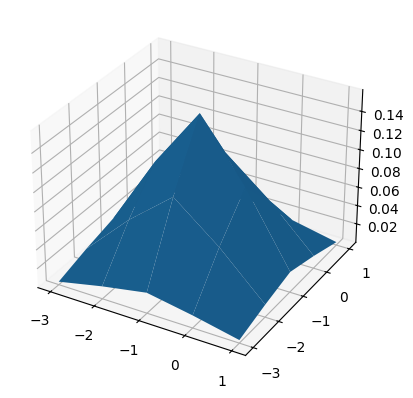

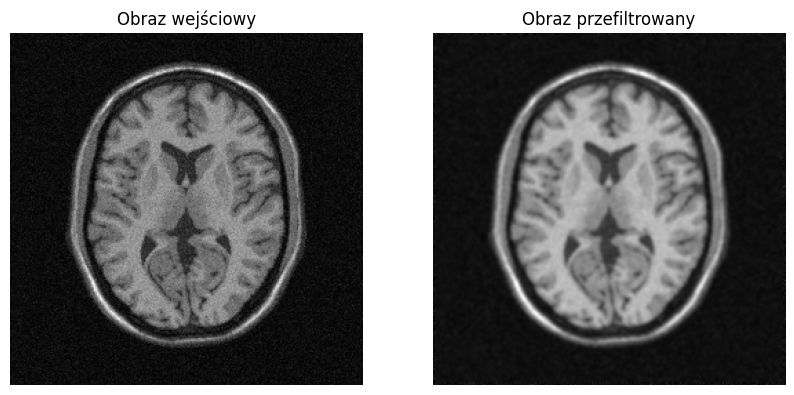

In [4]:
size = 5
var = 1
I_filtered_gauss = gauss_filter(I1,size,var)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(I1,'gray')
plt.title('Obraz wejściowy')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(I_filtered_gauss,'gray')
plt.title('Obraz przefiltrowany')
plt.axis('off')
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [5]:
def new_pixel2(window,f,varR):
    value = 0
    norm = 0
    mid_pixel = window[window.shape[0]//2,window.shape[1]//2]
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            diff = np.abs(mid_pixel-window[i,j])
            gamma = np.exp(-(diff**2)/(2*varR**2))
            value += window[i,j]*f[i,j]*gamma
            norm += gamma*f[i,j]
    return value/norm

def bilateral_filter(image,size,varS,varR):
    f = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            x = i - size//2
            y = j - size//2
            res = np.sqrt(x**2+y**2)
            f[i,j] = np.exp(-(res**2)/(2.0*varS*varS))
    IBilateral = image.copy()
    for i in range(size//2,image.shape[0]-size//2):
        for j in range(size//2,image.shape[1]-size//2):
            context = image[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            IBilateral[i,j] = new_pixel2(context,f,varR)
    return IBilateral

In [6]:
size = 5
varS = 2
varR = 20
I_filtered_bi = bilateral_filter(I1,size,varS,varR)

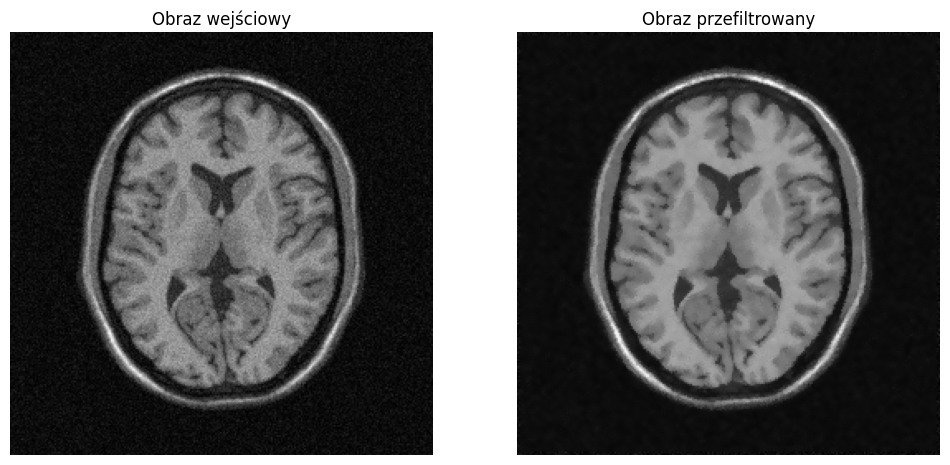

In [7]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(I1,'gray')
plt.title('Obraz wejściowy')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(I_filtered_bi,'gray')
plt.title('Obraz przefiltrowany')
plt.axis('off')
plt.show()

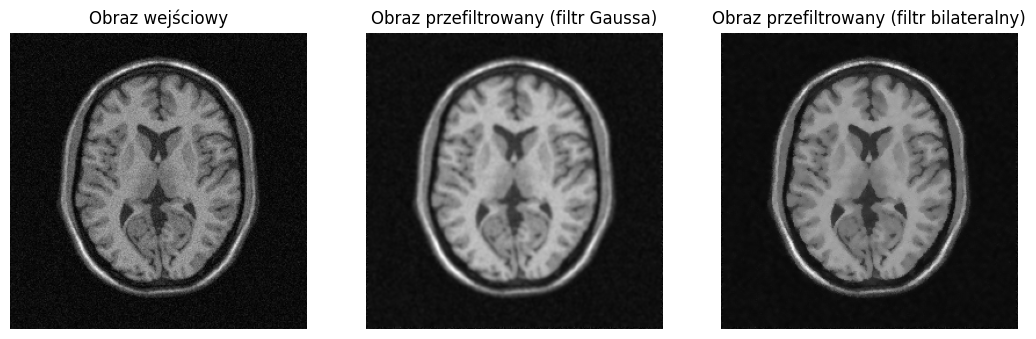

In [8]:
plt.figure(figsize=(13,13))

plt.subplot(1,3,1)
plt.imshow(I1,'gray')
plt.title('Obraz wejściowy')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(I_filtered_gauss,'gray')
plt.title('Obraz przefiltrowany (filtr Gaussa)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(I_filtered_bi,'gray')
plt.title('Obraz przefiltrowany (filtr bilateralny)')
plt.axis('off')
plt.show()

Filtr bilateralny poradził sobie z filtracją zdecydoawnie lepiej. W przeciwieństwie do filtra Gaussa, który rozmazał obraz, filtr bilateralny zachował ostrość krawędzi, co przyczyniło się do lepszej jakości wynikowego obrazu.